# Regressione Predict Podcast Listening Time

Progetto di programmazione di applicazioni data intensive a.a. 2024/2025 \
Realizzato da: Senni Mattia

Questo elaborato è basato su una competizione di kaggle [visualizzabile qui](https://www.kaggle.com/competitions/playground-series-s5e4/data?select=test.csv) \
Tutti i dataset sia train che test sono entrambi disponibili al link della competizione. 

## Istruzioni per il download del dataset
il Dataset va inserito all'interno della cartella /dataset. 
Il dataset è composto di 2 file test.csv e train.csv i rispettivi dataset di test e train.
Per procedere al download del dataset è necessario possedere un account Kaggle, generare un API key dalle impostazioni di kaggle e configurare il pacchetto python kaggle per il corretto funzionamento in locale.
Una volta configurato kaggle correttamente sarà sufficiente eseguire i seguente comandi all'interno della cartella `/dataset`: \
`kaggle competitions download -c playground-series-s5e4` e `unzip playground-series-s5e4.zip`

# Librerie
In questo primo step verranno importate le librerie necessarie alla corretta esecuzione di questo notebook \
- Pandas: libreria per la gestione di data frame (dati in forma tabellare)
- Matplotlib: libreria utile per la rappresentazione grafica dei dati
- Seaborn: libreria basata su matplotlib con il supporto di diversi tipi di grafici ad esempio gli heatmaps
- scikit-learn: libreria per il machine learning in python

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Analisi dati
In questo step si inizia a prendere confidenza con il dataset analizzandolo, studiando eventuali relazioni sui dati, sanificandolo nel casi ci siano valori non giusti (in quanto il dataset è sintetico quindi potrebbe avere qualche dato fuori posto). \
La colonna che dobbiamo predire è la colonna `Listening_Time_minutes`. 

Iniziamo subito cancellando la colonna Id inutile ai nostri fini in quanto non riporta alcuna relazione con la colonna `Listening_Time_minutes`.

In [285]:
df_train = pd.read_csv("dataset/train.csv")
df_train = df_train.drop(columns=["id"])
df_train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


Descrizione del dataset:
- Podcast_name: stringa, il nome del podcast
- Episode_Title: stringa, il nome dell'episodio Episode \<episode-id\>
- Episode_Length_minutes: float, La lunghezza dell'episodio in minuti
- Genre: stringa, Il genere dell'episodio
- Host_Popularity_Percentage: float, la popolarità del podcast
- Publication_Day: stringa, il giorno della settimana della pubblicazione del podcast
- Publication_Time: stringa, il momento della giornata della pubblicazione del podcast
- Guest_Popularity_percentage: float, la popolarità del guest
- Number_of_Ads: intero, Il numero di Ads durante l'ascolto
- Episode_Sentiment: stringa, il livello di approvazione della gente per quel podcast
- Listening_Time_minutes: int, variabile target, il tempo di ascolto del podcast

Procediamo visualizzando la distribuzione dei valori nulli nel dataset

In [286]:
from pandas import DataFrame
def print_missing_value_plot(df: DataFrame):
    df.isnull().sum().plot(kind='bar', title="Numero di elementi nulli nelle colonne del dataset")
    plt.figure(figsize=(12,6))
    plt.show()
    print(f"Numero di righe: {len(df)}")
    for col in df.columns:
        print(f"Colonna {col}, valori nulli: {df[col].isnull().sum()}")

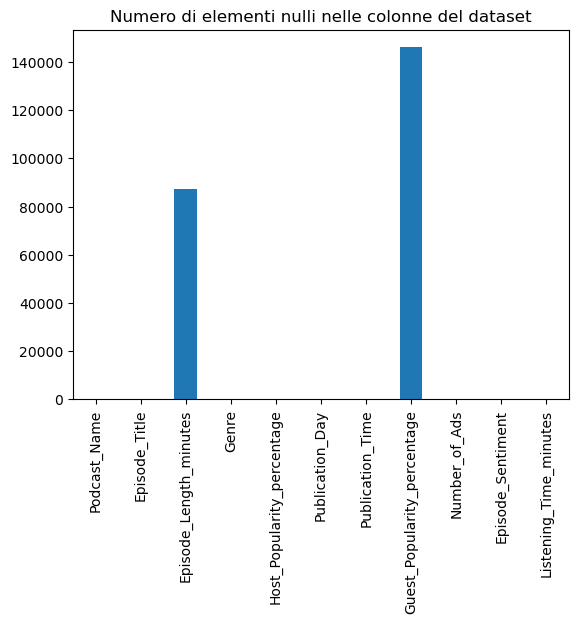

<Figure size 1200x600 with 0 Axes>

Numero di righe: 750000
Colonna Podcast_Name, valori nulli: 0
Colonna Episode_Title, valori nulli: 0
Colonna Episode_Length_minutes, valori nulli: 87093
Colonna Genre, valori nulli: 0
Colonna Host_Popularity_percentage, valori nulli: 0
Colonna Publication_Day, valori nulli: 0
Colonna Publication_Time, valori nulli: 0
Colonna Guest_Popularity_percentage, valori nulli: 146030
Colonna Number_of_Ads, valori nulli: 1
Colonna Episode_Sentiment, valori nulli: 0
Colonna Listening_Time_minutes, valori nulli: 0


In [287]:
print_missing_value_plot(df_train)

Dal grafico possiamo vedere che i valori nulli sono nelle colonne Episode_Length_minutes (dove mancano 80000 valori su 750000 righe), Guest_Popularity_percentage (dove mancano 140000 valori su 750000 righe) e Number_od_Ads (dove manca 1 valore su 750000 righe).
- Per gestire Episode_Length_minutes verrà scelto di eliminare le righe a cui manca questo valore, essendo che il data è sintetico si ipotizza che questi valori possano danneggiare le performance del modello (dal grafico sottostante possiamo infatti vedere che i valori mancanti sono valori di con `Listening_Time_minutes` distribuito su tutto il dataset una loro supposizione per termine mediano o per assegnamento di un valore uniforme ad ogni riga porterebbe alla creazione di rumore nella dipendenza lineare tra Episode_Length_minutes e Listening_Time_minutes ).
- Per gestire Guest_Popularity_percentage verrà messo il valore 0 alle righe mancanti aggiungendo poi un campo Guest_Popularity_missing con valore a 1 se Guest_Popularity_percentage è null, 0 altrimenti, assumendo che se manca il valore è perchè non è presente un ospite
- Per gestire Number_od_Ads verrà messo un valore di default a 0 assumendo che non ci siano state ads in quell'ascolto

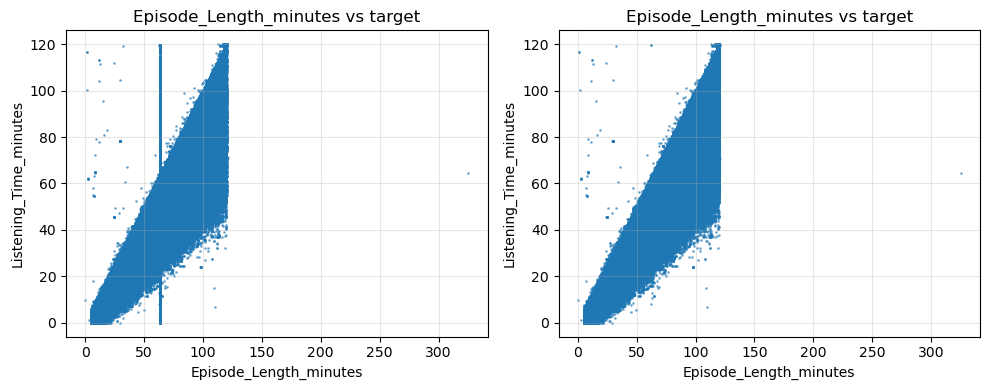

In [288]:
df_temp = df_train.copy()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.ravel()
target = "Listening_Time_minutes"

df_temp['Episode_Length_minutes'] = df_temp['Episode_Length_minutes'].fillna(df_temp['Episode_Length_minutes'].median())
axes[0].scatter(df_temp['Episode_Length_minutes'], df_temp['Listening_Time_minutes'], alpha=0.5, s=1)
axes[0].set_xlabel('Episode_Length_minutes')
axes[0].set_ylabel('Listening_Time_minutes')
axes[0].set_title('Episode_Length_minutes vs target')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(df_train['Episode_Length_minutes'], df_train['Listening_Time_minutes'], alpha=0.5, s=1)
axes[1].set_xlabel('Episode_Length_minutes')
axes[1].set_ylabel('Listening_Time_minutes')
axes[1].set_title('Episode_Length_minutes vs target')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Elimino anche il valore con episode length minute ~330 con listening time minute ~65 in quanto riga errata generata sinteticamente

In [289]:
df_train = df_train[(df_train['Episode_Length_minutes'] > 0) & (df_train['Episode_Length_minutes'] < 200)]

df_train['Guest_Popularity_missing'] = df_train['Guest_Popularity_percentage'].isna().astype(int)
df_train['Guest_Popularity_percentage'].fillna(0, inplace=True)

df_train["Number_of_Ads"].fillna(1, inplace=True)

/tmp/ipykernel_1514/1132878122.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['Guest_Popularity_percentage'].fillna(0, inplace=True)
/tmp/ipykernel_1514/1132878122.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

Procediamo ad analizzare la distribuzione dei valori per il campo `Listening_Time_minutes` rispetto agli altri valori del dataset.
Prima di procedere alla visualizzazione effettuo però un'operazione di pulizia dati, cancello tutte le righe che contengono valori non ammessi secondo i seguenti criteri
- Host_Popularity_percentage: valori da 0 a 100
- Guest_Popularity_percentage: valori da 0 a 100
- Number_of_Ads: valori da 0 a 3 ed interi
- Episode_Length_minutes: sempre minore di Listening_Time_minutes

In [290]:
df_train = df_train[
    (df_train['Host_Popularity_percentage'] >= 0) & (df_train['Host_Popularity_percentage'] <= 100) &
    (df_train['Guest_Popularity_percentage'] >= 0) & (df_train['Guest_Popularity_percentage'] <= 100) &
    (df_train['Number_of_Ads'].isin([0, 1, 2, 3])) &
    (df_train['Episode_Length_minutes'] >= df_train['Listening_Time_minutes'])
]

In [305]:
numerical_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage', 
                 'Guest_Popularity_percentage', 'Number_of_Ads']
categorical_cols = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

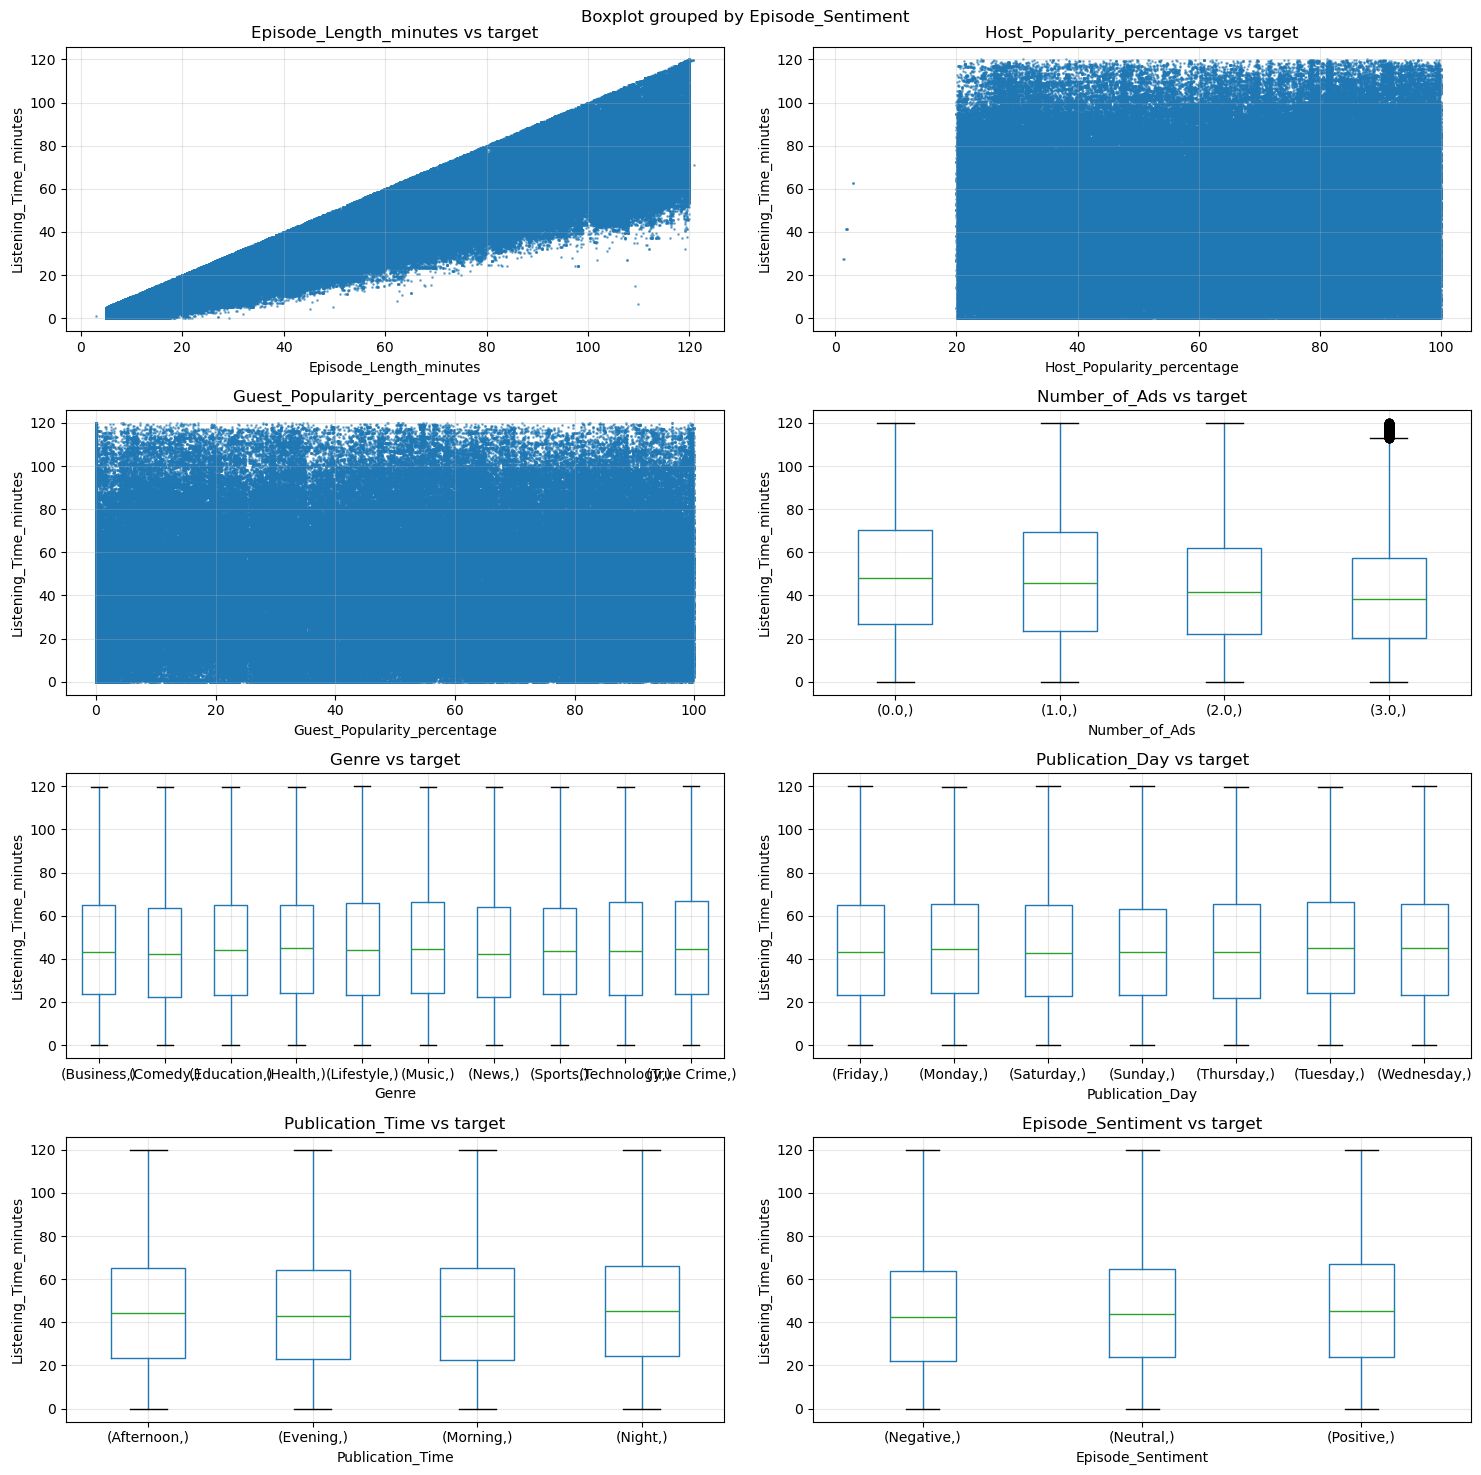

In [306]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
axes = axes.ravel()
target = "Listening_Time_minutes"

for i, col in enumerate(numerical_cols + categorical_cols):
    if col in df_train.columns:
        if col not in categorical_cols + ["Number_of_Ads"]:
            axes[i].scatter(df_train[col], df_train[target], alpha=0.5, s=1)
            axes[i].set_xlabel(col)
            axes[i].set_ylabel(target)
            axes[i].set_title(f'{col} vs target')
            axes[i].grid(True, alpha=0.3)
        else:
            df_train.boxplot(column=target, by=[col], ax=axes[i])
            axes[i].set_xlabel(col)
            axes[i].set_ylabel(target)
            axes[i].set_title(f'{col} vs target')
            axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [292]:
def print_unique_name(df, column_name):
    print(df[column_name].unique())
print_unique_name(df_train, "Publication_Day")
print_unique_name(df_train, "Publication_Time")
print_unique_name(df_train, "Episode_Sentiment")

['Saturday' 'Tuesday' 'Monday' 'Sunday' 'Thursday' 'Wednesday' 'Friday']
['Afternoon' 'Evening' 'Morning' 'Night']
['Negative' 'Positive' 'Neutral']


Nel prossimo step procederemo a gestire i campi testuali semplici ovvero quelli con valori predefiniti. I valori predefiniti sono:
- Publication_Day: 'Thursday' 'Saturday' 'Tuesday' 'Monday' 'Sunday' 'Wednesday' 'Friday'
- Publication_Time: 'Night' 'Afternoon' 'Evening' 'Morning'
- Episode_Sentiment: 'Positive' 'Negative' 'Neutral'
- Genre: 'True Crime' 'Comedy' 'Education' 'Technology' 'Health' 'News' 'Music' 'Sports' 'Business' 'Lifestyle'

Per gestirli mapperemo i relativo valori in numeri interi

In [293]:
day_order = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
df_train['Publication_Day_Numeric'] = df_train['Publication_Day'].map(day_order).fillna(0)

time_order = {'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4}
df_train['Publication_Time_Numeric'] = df_train['Publication_Time'].map(time_order).fillna(0)

sentiment_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
df_train['Episode_Sentiment_Numeric'] = df_train['Episode_Sentiment'].map(sentiment_map).fillna(0)

sentiment_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1}
df_train['Episode_Sentiment_Numeric'] = df_train['Episode_Sentiment'].map(sentiment_map).fillna(0)
print_unique_name(df_train, "Publication_Day_Numeric")
print_unique_name(df_train, "Publication_Time_Numeric")
print_unique_name(df_train, "Episode_Sentiment_Numeric")

[6 2 1 7 4 3 5]
[2 3 1 4]
[-1  1  0]
